## Import Libraries

In [1]:

import numpy as np
import pandas as pd
import time
from osgeo import gdal, gdal_array, osr
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from skimage import exposure
from sklearn.decomposition import PCA
import os, glob, cv2,  rasterio
import xarray as xr
import geopandas as gpd
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MinMaxScaler
import skimage 
from  skimage import color
from skimage import io
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Read IMG

In [3]:
image_path =(r'IMG.tif')
dataset = gdal.Open(image_path)
image = dataset.ReadAsArray()
geot = dataset.GetGeoTransform()
num_bands = dataset.RasterCount
print (num_bands)
width = dataset.RasterXSize
height = dataset.RasterYSize
spatial_ref = osr.SpatialReference()
spatial_ref.ImportFromWkt(dataset.GetProjection())
num_bands = dataset.RasterCount
# # Get the EPSG code
# epsg_code = spatial_ref.GetAttrValue('AUTHORITY', 1)
# print(gt)
# print('---------')
# print('Number of Band',num_bands)
# print('with',width)
# print('heght',height)
# print (pixelSizeX)
# print (pixelSizeY)
# print (epsg_code)

C:\Users\AFZALI_SAV\anaconda3\envs\hamid\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


1


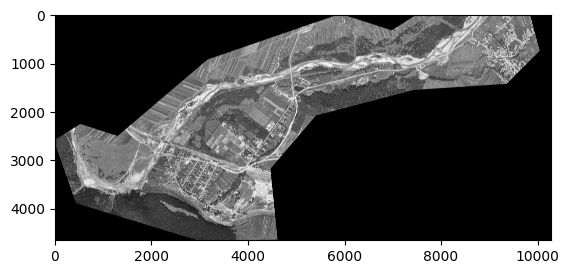

In [6]:
plt.imshow(image, cmap = 'gray')

# GLCM


In [7]:
# Gray IMG
img = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
print(img.min())
print(img.max())
print(img.dtype)
plt.imshow(img, cmap = 'gray')

## GLCM

In [11]:

def main():
    pass


def fast_glcm(img, vmin=0, vmax=255, levels=8, kernel_size=8, distance=1.0, angle=0):

    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, levels+1)
    gl1 = np.digitize(img, bins) - 1

    # make shifted image
    dx = distance*np.cos(np.deg2rad(angle))
    dy = distance*np.sin(np.deg2rad(-angle))
    mat = np.array([[1.0,0.0,-dx], [0.0,1.0,-dy]], dtype=np.float32)
    gl2 = cv2.warpAffine(gl1, mat, (w,h), flags=cv2.INTER_NEAREST,
                         borderMode=cv2.BORDER_REPLICATE)

    # make glcm
    glcm = np.zeros((levels, levels, h, w), dtype=np.uint8)
    for i in range(levels):
        for j in range(levels):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(levels):
        for j in range(levels):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm


def fast_glcm_mean(img, vmin=0, vmax=255, levels=8, ks=8, distance=1.0, angle=0.0):
    '''
    calc glcm mean
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, levels, ks, distance, angle)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(levels):
        for j in range(levels):
            mean += glcm[i,j] * i / (levels)**2

    return mean


def fast_glcm_std(img, vmin=0, vmax=255, levels=8, ks=8, distance=1.0, angle=0.0):
    '''
    calc glcm std
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, levels, ks, distance, angle)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(levels):
        for j in range(levels):
            mean += glcm[i,j] * i / (levels)**2

    std2 = np.zeros((h,w), dtype=np.float32)
    for i in range(levels):
        for j in range(levels):
            std2 += (glcm[i,j] * i - mean)**2

    std = np.sqrt(std2)
    return std


def fast_glcm_contrast(img, vmin=0, vmax=255, levels=8, ks=8, distance=1.0, angle=0.0):
    '''
    calc glcm contrast
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, levels, ks, distance, angle)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(levels):
        for j in range(levels):
            cont += glcm[i,j] * (i-j)**2

    return cont


def fast_glcm_dissimilarity(img, vmin=0, vmax=255, levels=8, ks=8, distance=1.0, angle=0.0):
    '''
    calc glcm dissimilarity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, levels, ks, distance, angle)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(levels):
        for j in range(levels):
            diss += glcm[i,j] * np.abs(i-j)

    return diss


def fast_glcm_homogeneity(img, vmin=0, vmax=255, levels=8, ks=8, distance=1.0, angle=0.0):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, levels, ks, distance, angle)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(levels):
        for j in range(levels):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo


def fast_glcm_ASM(img, vmin=0, vmax=255, levels=8, ks=8, distance=1.0, angle=0.0):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, levels, ks, distance, angle)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(levels):
        for j in range(levels):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene


def fast_glcm_max(img, vmin=0, vmax=255, levels=8, ks= 8, distance=1.0, angle=0.0):
    '''
    calc glcm max
    '''
    glcm = fast_glcm(img, vmin, vmax, levels, ks, distance, angle)
    max_  = np.max(glcm, axis=(0,1))
    return max_


def fast_glcm_entropy(img, vmin=0, vmax=255, levels=8, ks=8, distance=1.0, angle=0.0):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, levels, ks, distance, angle)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent


if __name__ == '__main__':
    main()

    levels = 8
    ks = 3 #defult =5
    mi, ma = 0, 255

    #img = data.camera()
    #h,w = img.shape

    #img[:,:w//2] = img[:,:w//2]//2+127
    #glcm_mean = fast_glcm_mean(img, mi, ma, levels, ks)

def fast_haralics(img, methods, distances, directions):

    glc = {}

    for method in methods:
         for distance in distances:
            for direction in directions:
                arr = method(
                    img, 
                    distance = distance, 
                    angle= direction
                    )
                glc[method.__name__, distance, direction] = arr


    return glc


# Reference code : 
# Taka Izumi 2021 , https://github.com/tzm030329/GLCM

In [12]:

s_time = time.time()

glcm_functions = [
    fast_glcm_mean,
    fast_glcm_std,            
    fast_glcm_contrast,
    fast_glcm_dissimilarity,
    fast_glcm_homogeneity,
    fast_glcm_ASM,
    fast_glcm_max,
    fast_glcm_entropy
            ]

glcm_distances = [1]
glcm_directions = [0]

ds_glcm = fast_haralics(image, glcm_functions, glcm_distances, glcm_directions)

e_time = time.time()
ex_time = (e_time - s_time)/60
print ('Execution Time:', ex_time, "Minutes")

Execution Time: 4.244651242097219 Minutes


In [16]:
glcm = [mean_glcm,std,con,dis,hom,asm,max,ent]

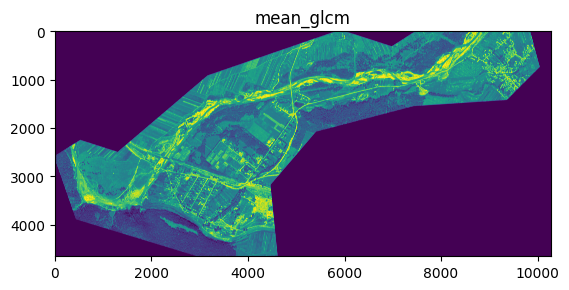

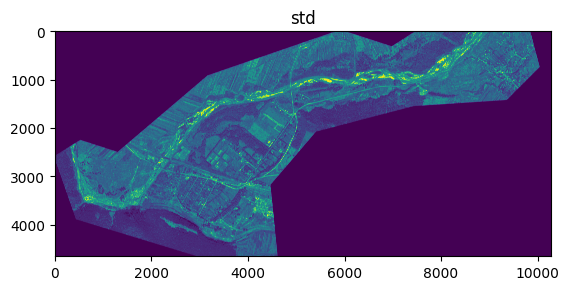

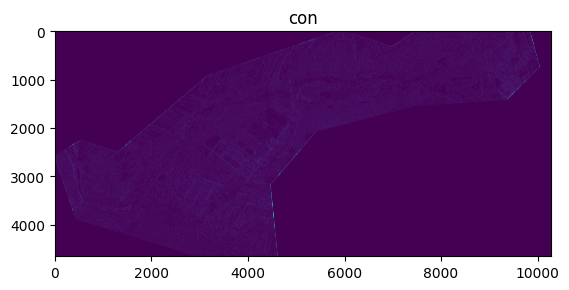

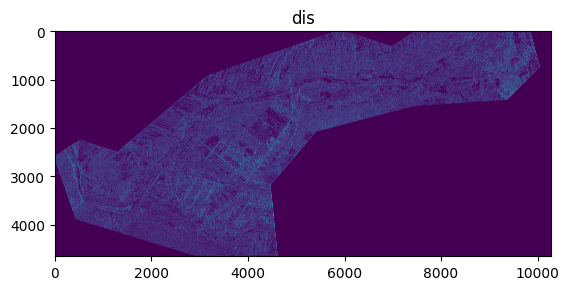

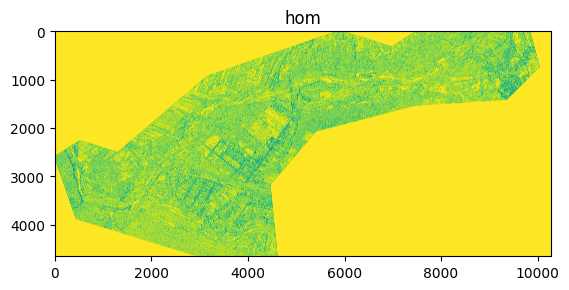

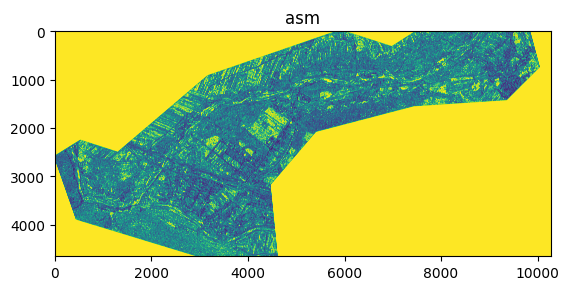

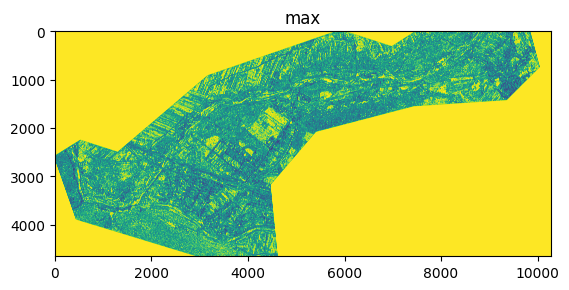

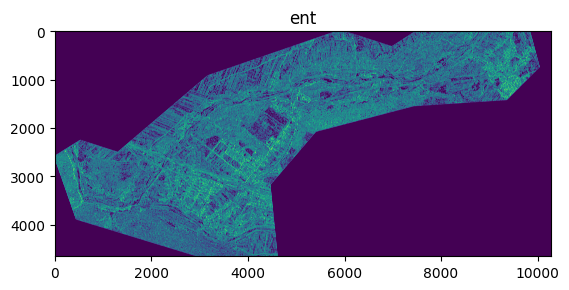

In [17]:
for j, image in zip(glcm , ['mean_glcm','std','con','dis','hom','asm', 'max' ,'ent']):
    plt.imshow(j )  
    plt.title(image)
    plt.show()

# Calculate texteral and Morpholigical Features

In [18]:
import skimage.feature
import skimage.filters as filters
import skimage.morphology
import skimage.color
import skimage.measure
from skimage.feature import graycomatrix, graycoprops
import time

In [19]:
# Calculate the closed and extract texture features

lbp = skimage.feature.local_binary_pattern(img, P=16, R=1)
hist, _ = np.histogram(lbp, density=True, bins=256, range=(0, 256))
entropy = -np.sum(hist*np.log2(hist+1e-7))



In [20]:
# Calculate the morphological features

eroded = skimage.morphology.erosion(img, skimage.morphology.disk(5))
dilated = skimage.morphology.dilation(img, skimage.morphology.disk(5))
gradient = dilated - eroded
mean_morph = skimage.filters.rank.mean(img, skimage.morphology.disk(5))
opened = skimage.morphology.opening(img, skimage.morphology.disk(5))

closed = skimage.morphology.closing(img, skimage.morphology.disk(5))
tophat = skimage.morphology.white_tophat(img, skimage.morphology.disk(5))
bothat = skimage.morphology.black_tophat(img, skimage.morphology.disk(5))

In [21]:
textural_features = [eroded, dilated, gradient, mean_morph, opened, closed, tophat, bothat]

In [22]:
# for j, image in zip(textural_features, ['eroded', 'dilated', 'gradient', 'mean_morph', 'opened', 'closed', 'tophat', 'bothat']):
#     plt.imshow(j)  
#     plt.title(image)
#     plt.show()

# Stack Features


In [23]:
std.shape

(4657, 10275)

In [24]:

#    GLCM features :  mean_glcm ,std,con,dis, hom, asm,max,ent 
#    Local Binary Pixel :  lbp 
#    Morphological features  :   eroded , dilated, gradient, mean_morph, opened, closed, tophat,bothat


all_features = np.concatenate((

    img[np.newaxis, :, :], #1
    mean_glcm[np.newaxis, :, :], #2
    std[np.newaxis, :, :],#3
    con[np.newaxis, :, :],#4
    dis[np.newaxis, :, :],#5
    hom[np.newaxis, :, :],#6
    asm[np.newaxis, :, :],#7
    max[np.newaxis, :, :],#8
    ent[np.newaxis, :, :],#9

    lbp[np.newaxis, :, :],#10
    
    eroded[np.newaxis, :, :],#11
    dilated[np.newaxis, :, :],#12
    gradient[np.newaxis, :, :],#13
    mean_morph[np.newaxis, :, :],#14
    opened[np.newaxis, :, :], #15
    closed[np.newaxis, :, :], #16
    tophat[np.newaxis, :, :], #17
    bothat[np.newaxis, :, :]),axis=0) #18 
    
final_img= all_features                        
print( 'Dataset shape :', all_features.shape)
print( 'Dataset data type :', final_img.dtype)
     

Dataset shape : (18, 4657, 10275)
Dataset data type : float64


In [25]:
# num_bands= final_img.shape[0]
# for band in range(num_bands):
#     min_value = np.min(final_img[band, :, :])
#     max_value = np.max(final_img[band, :, :])
#     print(f"Band {band + 1}: Min = {min_value}, Max  = {max_value}")

Uint8

In [26]:
normalized_bands = []

# Normalize each band
for band_idx in range(final_img.shape[0]):

    # Access each band individually
    current_band = final_img[band_idx]
    normalized_band = exposure.rescale_intensity(current_band, in_range='image', out_range=(0, 1))
    
    # Apply gamma correction
    # gamma = 1.5
    # gamma_corrected_band = exposure.equalize_adapthist(normalized_band)
    normalized_bands.append(normalized_band)

In [27]:
len(normalized_bands)

18

In [28]:
num_bands = len(normalized_bands)

In [29]:
normalized_bands[0].dtype

dtype('float64')

In [30]:

num_bands = len(normalized_bands)
geot = dataset.GetGeoTransform()
# Create a new output dataset
output_path=(r'IMG_f32.tif')
driver = gdal.GetDriverByName('GTiff')
output_dataset = driver.Create(output_path, width, height, num_bands, gdal.GDT_Float32)

# Set the geotransform and projection
output_dataset.SetGeoTransform(geot)
output_dataset.SetProjection(dataset.GetProjection())

# Write the normalized bands to the output dataset
for band_idx, normalized_band in enumerate(normalized_bands):
    output_band = output_dataset.GetRasterBand(band_idx + 1)
    output_band.WriteArray(normalized_band)

output_dataset = None  # Close the output dataset
print(f'18 bands Imgae has been saved {output_path}')

18 bands Imgae has been saved E:\Classification_Bela\1949\IMG\1949_6_f32.tif
